In [3]:
import os
import json

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import math
from prettytable import PrettyTable


# ViT CIFAR 100

This is our main ViT implementation from Scratch. For CIFAR 100, the only thing that we change is that we change the MLP head to integrate an intemediate representation s.t that we go from **embed -> intermediate -> intermediate/2 -> logits** instead of **embed -> intemediate -> logits**. 

In [5]:
class PatchEmbeddings(nn.Module):
    """
    parameters: Image_size, patch_size, num_channels, embed_dim
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.embed = config["embed_dim"]

        # no. of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2 # from (HW)/P^2

        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size embed_dim
        self.projection = nn.Conv2d(self.num_channels, self.embed, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, embed_dim)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)

        # Creating a learnable [CLS] token


        # the nn.parameter creates a learnable tensor updated by backpropogation
        # we create a random vector from normal distribution along (1, 1, 48)

        self.cls_token = nn.Parameter(torch.randn(1, 1, config["embed_dim"]))

        # Creating learnable position embeddings for the [CLS] token and patches
        # Add 1 to the sequence length for the [CLS] token

        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["embed_dim"]))

        self.dropout = nn.Dropout(config["dropout_val"])

    def forward(self, x):

        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()

        # Expand the [CLS] token to the batch size
        # (1, 1, embed_dim) -> (batch_size, 1, embed_dim)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)

        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)

        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x
    
class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.
    """
    def __init__(self, embed_dim, attention_head_dim, dropout, bias=True):
        super().__init__()
        self.embed = embed_dim
        self.attention_head_dim = attention_head_dim
        # Create the query, key, and value projection layers
        self.query = nn.Linear(embed_dim, attention_head_dim, bias=bias)
        self.key = nn.Linear(embed_dim, attention_head_dim, bias=bias)
        self.value = nn.Linear(embed_dim, attention_head_dim, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.

        # (batch_size, sequence_length, embed_dim)
        # transforms to
        # -> (batch_size, sequence_length, attention_head_dim)


        query = self.query(x)
        key = self.key(x)
        value = self.value(x)


        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V

        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_dim)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)

        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)

        return (attention_output, attention_probs)


class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.embed = config["embed_dim"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_dim = self.embed // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_dim

        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]

        # Create a list of attention heads

        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.embed,
                self.attention_head_dim,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)

        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and embed_dim are the same
        self.output_projection = nn.Linear(self.all_head_size, self.embed)
        self.output_dropout = nn.Dropout(config["dropout_val"])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)

class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["embed_dim"], config["hidden_dim"])
        self.activation = nn.GELU()
        self.dense_intermediate = nn.Linear(config["hidden_dim"], config["hidden_dim"]//2)
        self.dense_2 = nn.Linear(config["hidden_dim"]//2, config["embed_dim"])
        self.dropout = nn.Dropout(config["dropout_val"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_intermediate(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x
    
class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["embed_dim"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["embed_dim"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)
        
class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)
        
class ViTForClassification(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.embed = config["embed_dim"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.embed, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)




# Utils

The same utils save_experiment, save_checkpoint, load_experiment, visualize_images.

In [6]:
def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


def visualize_images():
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]
    # Visualize the images using matplotlib
    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])


@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()
    # Load random images
    num_images = 30
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]
    # Convert the images to tensors
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    images = torch.stack([test_transform(image) for image in raw_images])
    # Move the images to the device
    images = images.to(device)
    model = model.to(device)
    # Get the attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)
    # Get the predictions
    predictions = torch.argmax(logits, dim=1)
    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)
    # select only the attention maps of the CLS token
    attention_maps = attention_maps[:, :, 0, 1:]
    # Then average the attention maps of the CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)
    # Reshape the attention maps to a square
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    # Resize the map to the size of the image
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    # Plot the images and the attention maps
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)
        # Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt==pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()







# Trainer & Prepare Data function

In [7]:

class Modified_Trainer:
    def __init__(self, model, optimizer, loss_fn, exp_name, device,config, base_dir="experiments"):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        self.base_dir = base_dir
        self.config = config 

    def train(self, trainloader, testloader, epochs,save_model_every_n_epochs, output_attentions=False):
        train_losses, test_losses, accuracies = [], [], []
        all_epoch_attentions = []  # Collect attention from all epochs

        for i in range(epochs):
            if output_attentions:
                train_loss, epoch_attentions = self.train_epoch(trainloader, output_attentions=True)
                all_epoch_attentions.append(epoch_attentions)  # Store attention data
            else:
                train_loss = self.train_epoch(trainloader)

            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0:
                save_checkpoint(self.exp_name, self.model, f"epoch_{i+1}", base_dir=self.base_dir)
                print(f'\tSaving checkpoint at epoch {i+1}')

        save_experiment(self.exp_name, self.config , self.model, train_losses, test_losses, accuracies, base_dir=self.base_dir)
        print(f'Final model and experiment details saved under {self.exp_name}')

        return all_epoch_attentions if output_attentions else None

    def train_epoch(self, trainloader, output_attentions=False):
        self.model.train()
        total_loss = 0
        block_attentions = []  # to store attention probabilities if needed

        for _, (images, labels) in enumerate(trainloader):
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()

            # Check if attention probabilities are needed
            if output_attentions:
                logits, attention_probs = self.model(images, output_attentions=True)
                block_attentions.append(attention_probs)
            else:
                logits, _ = self.model(images)

            loss = self.loss_fn(logits, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * len(images)

        average_loss = total_loss / len(trainloader.dataset)

        if output_attentions:
            return average_loss, block_attentions  # Optionally return attention data
        return average_loss

    def evaluate(self, testloader):
        self.model.eval()
        total_loss, correct = 0, 0
        for _, (images, labels) in enumerate(testloader):
            images, labels = images.to(self.device), labels.to(self.device)
            logits, _ = self.model(images)
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

def modified_prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    # TRAINING TRANSFORMATION
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32),antialias=True),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    trainset = torchvision.datasets.CIFAR100('./', train=True, download=True, transform =train_transform)



    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)

    # TEST TRANSFORMATIONS
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32),antialias=True),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = torchvision.datasets.CIFAR100('./', train=False, download=True, transform =test_transform)



    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

    # Update classes for CIFAR-100
    classes = tuple(f"class_{i+1}" for i in range(100))  # Placeholder for actual class names, update as needed

    return trainloader, testloader, classes


# TS-trainer

In [8]:

class TS_Trainer:
    def __init__(self, teacher_model, student_model, optimizer_teacher, optimizer_student, loss_fn, exp_name, device,alpha, base_dir="experiments"):
        self.teacher_model = teacher_model.to(device)
        self.student_model = student_model.to(device)

        self.optimizer_teacher = optimizer_teacher
        self.optimizer_student = optimizer_student
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        self.base_dir = base_dir
        self.alpha = alpha


    def train_epoch_teacher(self, trainloader):
        self.teacher_model.train()
        total_loss = 0
        for _, (images, labels) in enumerate(trainloader):
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer_teacher.zero_grad()
            logits = self.teacher_model(images)[0]
            loss = self.loss_fn(logits, labels)
            loss.backward()
            self.optimizer_teacher.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    def train_epoch_student(self,trainloader):
        self.student_model.train()
        total_loss = 0
        total_attention_loss = 0 
        total_classification_loss = 0 
        #kl_div_loss = nn.KLDivLoss(reduction='batchmean')  # Initialize KL divergence loss
        
        for _, (images, labels) in enumerate(trainloader):
          images, labels = images.to(self.device), labels.to(self.device)
          self.optimizer_student.zero_grad()
          # obtaining logits and attention
          student_logits, student_attention = self.student_model(images, output_attentions=True)
          with torch.no_grad(): # ENSURing THAT WE DON'T TRAIN THE TEACHER.
            _, teacher_attention = self.teacher_model(images, output_attentions=True) # we only need attention

          # Compute losses
          classification_loss = self.loss_fn(student_logits, labels)
          
          teacher_attention_block = teacher_attention[0]
          student_attention_block = student_attention[0]

          #LETS compute MSE loss this time 
          mse_loss_fn = nn.MSELoss()
          attention_loss = mse_loss_fn(student_attention_block, teacher_attention_block)
          
          #print("classification loss is , " ,classification_loss.item())
          #print("attention loss is , " ,attention_loss.item())
          
          weighted_classification = self.alpha * classification_loss
          weighted_attention = (1 - self.alpha) * attention_loss
          


          loss = weighted_classification + weighted_attention

          # Backward and optimize
          loss.backward()
          self.optimizer_student.step()
          total_loss += loss.item() * images.size(0)
          total_classification_loss += weighted_classification.item()* images.size(0)
          total_attention_loss += weighted_attention.item()* images.size(0)

        total_loss = total_loss / len(trainloader.dataset)
        total_classification_loss = total_classification_loss / len(trainloader.dataset)
        total_attention_loss = total_attention_loss/len(trainloader.dataset)

        # Normalizing attention is reducing the value by too much.
        # However, that might just be because for now I am testing on a teacher model
        # that has not been trained properly.

        print("total attention loss is ",total_attention_loss)
        print("total classification loss is ",total_classification_loss )

        return total_loss, total_classification_loss, total_attention_loss


    def evaluate_teacher(self, testloader):
        self.teacher_model.eval()
        total_loss, correct = 0, 0
        for _, (images, labels) in enumerate(testloader):
            images, labels = images.to(self.device), labels.to(self.device)
            logits, _ = self.teacher_model(images)
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

    def evaluate_student(self, testloader):
        self.student_model.eval()
        total_loss, correct = 0, 0
        for _, (images, labels) in enumerate(testloader):
            images, labels = images.to(self.device), labels.to(self.device)
            logits, _ = self.student_model(images)
            # WE COMPUTE ONLY CLASSIFICATION LOSS WHEN EVALUATING STUDENT.
            # NO DISTILLATION LOSS COMPUTED HERE.
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss




    def train_teacher(self, config, trainloader,testloader, epochs,save_model_every_n_epochs=0):

        train_losses, test_losses, accuracies = [], [], []
        self.teacher_model.train()
        for i in range(epochs):
          train_loss = self.train_epoch_teacher(trainloader)
          accuracy, test_loss = self.evaluate_teacher(testloader)
          train_losses.append(train_loss)
          test_losses.append(test_loss)
          accuracies.append(accuracy)
          print(f"Epoch: {i+1}, Teacher Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

          # Save checkpoint if required
          if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0:
              save_checkpoint(self.exp_name, self.teacher_model, f"epoch_{i+1}", base_dir=self.base_dir)
              print(f'\tSaving checkpoint at epoch {i+1}')

        # Save the final model and experiment details at the end of training
        save_experiment(self.exp_name, config, self.teacher_model, train_losses, test_losses, accuracies, base_dir=self.base_dir)
        print(f'teacher_final and experiment details saved under {self.exp_name}')

# THIS IS THE ACTUAL NOVELTY. WE EMPLEMENT THIS FROM SCRATCH.
    def train_student(self, config, trainloader,testloader, epochs,save_model_every_n_epochs):
        train_losses, test_losses, attention_losses, accuracies = [], [], [],[]
        self.student_model.train()
        for i in range(epochs):
          train_loss, classification_loss, attention_loss = self.train_epoch_student(trainloader)
          accuracy, test_loss = self.evaluate_student(testloader)
          train_losses.append(train_loss)
          test_losses.append(test_loss)
          attention_losses.append(attention_loss)
          accuracies.append(accuracy)
          print(f"Epoch: {i+1}, Student Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f},Attention Loss: {attention_loss:.4f}, Accuracy: {accuracy:.4f}")

          # Save checkpoint if required
          if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0:
              save_checkpoint(self.exp_name, self.student_model, f"epoch_{i+1}", base_dir=self.base_dir)
              print(f'\tSaving checkpoint at epoch {i+1}')

        # Save the final model and experiment details at the end of training
        save_experiment(self.exp_name, config, self.student_model, train_losses, test_losses, accuracies, base_dir=self.base_dir)
        print(f'student_final and experiment details saved under {self.exp_name}')


# Training 

In [ ]:

config_teacher = {
    "patch_size": 8,  # Input image size: 32x32 -> 8x8 patches
    "embed_dim": 64,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "hidden_dim": 64 * 16, ## 32 * embed_dim -> i think this helped increase accuracy on CIFAR100
    "dropout_val": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100, # num_classes of CIFAR100
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
    "attention_block_index": 1  # Specify the block index you want to observe
}


config_student = {
    "patch_size": 8,  # Input image size: 32x32 -> 8x8 patches
    "embed_dim": 64,
    "num_hidden_layers": 3,
    "num_attention_heads": 4,
    "hidden_dim": 64 * 8, ## 32 * embed_dim -> i think this helped increase accuracy on CIFAR100
    "dropout_val": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100, # num_classes of CIFAR100
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
    "attention_block_index": 1  # Specify the block index you want to observe
}




exp_name = "ViT_Student_teacher"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


teacher_model = ViTForClassification(config_teacher)
student_model = ViTForClassification(config_student)

optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001)
optimizer_student = optim.Adam(student_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

save_model_every_n_epochs = 5
epoch_teacher = 1  # Adjust the number of epochs as needed
epoch_student = 1  # Adjust the number of epochs as needed
batch_size = 64  # Adjust the batch size as needed
trainloader, testloader, _ = modified_prepare_data(batch_size)


alpha = 0.5 # THIS DEFINES THE WEIGHTED LOSS. IF ALPHA IS LESS THAN 0.5, THEN MORE EMPHASIS ON ATTENTION LOSS. 

#0.9847


trainer = TS_Trainer(teacher_model, student_model, optimizer_teacher, optimizer_student, loss_fn,exp_name, device,alpha, base_dir="experiments")
trainer.train_teacher(config_teacher, trainloader,testloader, epoch_teacher,save_model_every_n_epochs)  # Train teacher for 100 epochs
trainer.train_student(config_student,trainloader,testloader, epoch_student,save_model_every_n_epochs)  # Train student for 100 epochs



# Visualizing TS Attention Blocks

In [ ]:
import torchvision.datasets as datasets
import numpy as np

def TS_visualize_attention(teacher_model, student_model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images for both teacher and student models on CIFAR-100.
    """
    teacher_model.eval()
    student_model.eval()

    # Load random images from CIFAR-100
    num_images = 5
    testset = datasets.CIFAR100(root='./data', train=False, download=True) # importing CIFAR100
    classes = testset.classes
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices] # randomly obtaining i images from CIFAR 100
    labels = [testset[i][1] for i in indices] # obtaining the associated labels

    # Convert images to tensors
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    images = images.to(device)

    # Get attention maps for both teacher and student models
    with torch.no_grad():  # Disable gradient computation
        teacher_logits, teacher_attention = teacher_model(images, output_attentions=True)
        student_logits, student_attention = student_model(images, output_attentions=True)

    # Get predictions
    teacher_predictions = torch.argmax(teacher_logits, dim=1)
    student_predictions = torch.argmax(student_logits, dim=1)

    # The attention map on which we imposed the constraint that it should mimic the teacher_attention and student_attention

    teacher_attention = teacher_attention[0]
    student_attention = student_attention[0]
    print(teacher_attention.shape)
    print(student_attention.shape)

    teacher_attention = teacher_attention[:, :, 0, 1:].mean(dim=1)
    student_attention = student_attention[:, :, 0, 1:].mean(dim=1)

    # Reshape attention maps to square and resize
    num_patches = teacher_attention.size(-1)
    size = int(math.sqrt(num_patches))
    teacher_attention = teacher_attention.view(-1, size, size)
    student_attention = student_attention.view(-1, size, size)
    teacher_attention = teacher_attention.unsqueeze(1)
    student_attention = student_attention.unsqueeze(1)

    teacher_attention = F.interpolate(teacher_attention, size=(32, 32), mode='bilinear', align_corners=False)
    student_attention = F.interpolate(student_attention, size=(32, 32), mode='bilinear', align_corners=False)
    teacher_attention = teacher_attention.squeeze(1)
    student_attention = student_attention.squeeze(1)

    # Plot images and attention maps for teacher and student
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 8))
    for i in range(num_images):
        axes[i, 0].imshow(raw_images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {i+1}")

        axes[i, 1].imshow(teacher_attention[i].detach().cpu(), cmap='jet')  # Detach and move to CPU for visualization
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Teacher Attention\nPrediction: {classes[teacher_predictions[i].item()]}")

        axes[i, 2].imshow(student_attention[i].detach().cpu(), cmap='jet')  # Detach and move to CPU for visualization
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Student Attention\nPrediction: {classes[student_predictions[i].item()]}")

    plt.tight_layout()
    if output is not None:
        plt.savefig(output)
    plt.show()


TS_visualize_attention(teacher_model, student_model, output=None, device=device)



In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

def TS_visualize_attention(teacher_model, student_model, output=None, device="cuda"):

    teacher_model.eval()
    student_model.eval()
    # Load random images from CIFAR-100
    num_images = 5
    testset = datasets.CIFAR100(root='./data', train=False, download=True) # importing CIFAR100
    classes = testset.classes
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices] # randomly obtaining i images from CIFAR 100
    labels = [testset[i][1] for i in indices] # obtaining the associated labels
    # Convert images to tensors
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    images = images.to(device)
    # Get attention maps for both teacher and student models
    with torch.no_grad():  # Disable gradient computation
        teacher_logits, teacher_attention = teacher_model(images, output_attentions=True)
        student_logits, student_attention = student_model(images, output_attentions=True)
        
    # Get predictions
    teacher_predictions = torch.argmax(teacher_logits, dim=1)
    student_predictions = torch.argmax(student_logits, dim=1)

    # The attention map on which we imposed the constraint that it should mimic the teacher_attention and student_attention

    teacher_attention = teacher_attention[0]
    student_attention = student_attention[0]
    print(teacher_attention.shape)
    print(student_attention.shape)

    teacher_attention = teacher_attention[:, :, 0, 1:].mean(dim=1)
    student_attention = student_attention[:, :, 0, 1:].mean(dim=1)

    # Reshape attention maps to square and resize
    num_patches = teacher_attention.size(-1)
    size = int(math.sqrt(num_patches))
    teacher_attention = teacher_attention.view(-1, size, size)
    student_attention = student_attention.view(-1, size, size)
    teacher_attention = teacher_attention.unsqueeze(1)
    student_attention = student_attention.unsqueeze(1)

    teacher_attention = F.interpolate(teacher_attention, size=(32, 32), mode='bilinear', align_corners=False)
    student_attention = F.interpolate(student_attention, size=(32, 32), mode='bilinear', align_corners=False)
    teacher_attention = teacher_attention.squeeze(1)
    student_attention = student_attention.squeeze(1)

    # Instead of plotting in a single figure, create a PDF to store all the plots
    with matplotlib.backends.backend_pdf.PdfPages(output if output else "output.pdf") as pdf:
        for i in range(num_images):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Image
            axes[0].imshow(raw_images[i])
            axes[0].axis('off')
            axes[0].set_title(f"Image {i+1}")

            # Teacher Attention
            axes[1].imshow(teacher_attention[i].detach().cpu(), cmap='jet')  # Detach and move to CPU for visualization
            axes[1].axis('off')
            axes[1].set_title(f"Teacher Attention\nPrediction: {classes[teacher_predictions[i].item()]}")

            # Student Attention
            axes[2].imshow(student_attention[i].detach().cpu(), cmap='jet')  # Detach and move to CPU for visualization
            axes[2].axis('off')
            axes[2].set_title(f"Student Attention\nPrediction: {classes[student_predictions[i].item()]}")

            pdf.savefig(fig)  # saves the current figure into a pdf page
            plt.close(fig)  # close the figure to avoid displaying it in the notebook

# Call the function with the output file name
TS_visualize_attention(teacher_model, student_model, output="attention_maps.pdf", device=device)

# Visualizing Non-TS attention blocks

In [ ]:
def NonTS_visualize_attention(teacher_model, student_model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images for both teacher and student models on CIFAR-100.
    """
    teacher_model.eval()
    student_model.eval()

    # Load random images from CIFAR-100
    num_images = 4
    testset = datasets.CIFAR100(root='./data', train=False, download=True) # importing CIFAR100
    classes = testset.classes
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices] # randomly obtaining i images from CIFAR 100
    labels = [testset[i][1] for i in indices] # obtaining the associated labels

    # Convert images to tensors
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    images = images.to(device)

    # Get attention maps for both teacher and student models
    with torch.no_grad():  # Disable gradient computation
        teacher_logits, teacher_attention = teacher_model(images, output_attentions=True)
        student_logits, student_attention = student_model(images, output_attentions=True)

    # Get predictions
    teacher_predictions = torch.argmax(teacher_logits, dim=1)
    student_predictions = torch.argmax(student_logits, dim=1)

    # The attention map on which we imposed the constraint that it should mimic the teacher_attention and student_attention

    teacher_attention = teacher_attention[1]
    student_attention = student_attention[1]

    teacher_attention = teacher_attention[:, :, 0, 1:].mean(dim=1)
    student_attention = student_attention[:, :, 0, 1:].mean(dim=1)

    # Reshape attention maps to square and resize
    num_patches = teacher_attention.size(-1)
    size = int(math.sqrt(num_patches))
    teacher_attention = teacher_attention.view(-1, size, size)
    student_attention = student_attention.view(-1, size, size)
    teacher_attention = teacher_attention.unsqueeze(1)
    student_attention = student_attention.unsqueeze(1)

    teacher_attention = F.interpolate(teacher_attention, size=(32, 32), mode='bilinear', align_corners=False)
    student_attention = F.interpolate(student_attention, size=(32, 32), mode='bilinear', align_corners=False)
    teacher_attention = teacher_attention.squeeze(1)
    student_attention = student_attention.squeeze(1)

    # Plot images and attention maps for teacher and student
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 8))
    for i in range(num_images):
        axes[i, 0].imshow(raw_images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {i+1}")

        axes[i, 1].imshow(teacher_attention[i].detach().cpu(), cmap='jet')  # Detach and move to CPU for visualization
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Teacher Attention\nPrediction: {classes[teacher_predictions[i].item()]}")

        axes[i, 2].imshow(student_attention[i].detach().cpu(), cmap='jet')  # Detach and move to CPU for visualization
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Student Attention\nPrediction: {classes[student_predictions[i].item()]}")

    plt.tight_layout()
    if output is not None:
        plt.savefig(output)
    plt.show()


NonTS_visualize_attention(teacher_model, student_model, output=None, device=device)



## Experiment 2 : Alpha 0.015 

In [ ]:
config_teacher = {
    "patch_size": 8,  # Input image size: 32x32 -> 8x8 patches
    "embed_dim": 64,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "hidden_dim": 64 * 16, ## 32 * embed_dim -> i think this helped increase accuracy on CIFAR100
    "dropout_val": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100, # num_classes of CIFAR100
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
    "attention_block_index": 1  # Specify the block index you want to observe
}


config_student = {
    "patch_size": 8,  # Input image size: 32x32 -> 8x8 patches
    "embed_dim": 64,
    "num_hidden_layers": 3,
    "num_attention_heads": 4,
    "hidden_dim": 64 * 8, ## 32 * embed_dim -> i think this helped increase accuracy on CIFAR100
    "dropout_val": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100, # num_classes of CIFAR100
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
    "attention_block_index": 1  # Specify the block index you want to observe
}




exp_name = "ViT_Student_teacher"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


teacher_model = ViTForClassification(config_teacher)
student_model = ViTForClassification(config_student)

optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001)
optimizer_student = optim.Adam(student_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

save_model_every_n_epochs = 5
epoch_teacher = 100  # Adjust the number of epochs as needed
epoch_student = 100  # Adjust the number of epochs as needed
batch_size = 64  # Adjust the batch size as needed
trainloader, testloader, _ = modified_prepare_data(batch_size)


alpha = 0.015 # THIS DEFINES THE WEIGHTED LOSS. IF ALPHA IS LESS THAN 0.5, THEN MORE EMPHASIS ON ATTENTION LOSS. 

#0.9847


trainer = TS_Trainer(teacher_model, student_model, optimizer_teacher, optimizer_student, loss_fn,exp_name, device,alpha, base_dir="experiments")
trainer.train_teacher(config_teacher, trainloader,testloader, epoch_teacher,save_model_every_n_epochs)  # Train teacher for 100 epochs
trainer.train_student(config_student,trainloader,testloader, epoch_student,save_model_every_n_epochs)  # Train student for 100 epochs



# Visualizing Attention Maps 

This one is a better function. Lets see how it changes the game. 

In [ ]:
import torchvision.datasets as datasets
import numpy as np

def TS_visualize_attention(teacher_model, student_model, output=None, device="cuda", num_images=30):
    """
    Visualize the attention maps of the images for both teacher and student models on CIFAR-100.
    """
    teacher_model.eval()
    student_model.eval()

    # Load random images from CIFAR-100
    testset = datasets.CIFAR100(root='./data', train=False, download=True)  # importing CIFAR100
    classes = testset.classes
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]  # randomly obtaining images from CIFAR 100
    labels = [testset[i][1] for i in indices]  # obtaining the associated labels

    # Convert images to tensors
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    images = images.to(device)

    # Get attention maps for both teacher and student models
    with torch.no_grad():  # Disable gradient computation
        teacher_logits, teacher_attention = teacher_model(images, output_attentions=True)
        student_logits, student_attention = student_model(images, output_attentions=True)

    teacher_predictions = torch.argmax(teacher_logits, dim=1)
    student_predictions = torch.argmax(student_logits, dim=1)
    
    teacher_attention = teacher_attention[0]  
    student_attention = student_attention[0]


    teacher_attention = teacher_attention[:, :, 0, 1:].mean(dim=1)
    student_attention = student_attention[:, :, 0, 1:].mean(dim=1)
    
    # Reshape and process attention maps
    num_patches = teacher_attention.size(-1)
    size = int(math.sqrt(num_patches))
    teacher_attention = teacher_attention.view(-1, size, size)
    student_attention = student_attention.view(-1, size, size)
    teacher_attention = F.interpolate(teacher_attention.unsqueeze(1), size=(32, 32), mode='bilinear', align_corners=False).squeeze(1)
    student_attention = F.interpolate(student_attention.unsqueeze(1), size=(32, 32), mode='bilinear', align_corners=False).squeeze(1)

    # Plot images and attention maps
    cols = 3
    rows = num_images
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*num_images))  # Adjusted size for better visualization
    for i in range(num_images):
        axes[i, 0].imshow(raw_images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {i+1}")

        axes[i, 1].imshow(teacher_attention[i].detach().cpu(), cmap='jet')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Teacher Attention\nPrediction: {classes[teacher_predictions[i].item()]}")

        axes[i, 2].imshow(student_attention[i].detach().cpu(), cmap='jet')
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Student Attention\nPrediction: {classes[student_predictions[i].item()]}")

    plt.tight_layout()
    if output is not None:
        plt.savefig(output)
    plt.show()

TS_visualize_attention(teacher_model, student_model, output=None, device='cuda')

# Non VS visualization

In [ ]:
import torchvision.datasets as datasets
import numpy as np

def NonTS_visualize_attention(teacher_model, student_model, output=None, device="cuda", num_images=30):
    """
    Visualize the attention maps of the images for both teacher and student models on CIFAR-100.
    """
    teacher_model.eval()
    student_model.eval()

    # Load random images from CIFAR-100
    testset = datasets.CIFAR100(root='./data', train=False, download=True)  # importing CIFAR100
    classes = testset.classes
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]  # randomly obtaining images from CIFAR 100
    labels = [testset[i][1] for i in indices]  # obtaining the associated labels

    # Convert images to tensors
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    images = images.to(device)

    # Get attention maps for both teacher and student models
    with torch.no_grad():  # Disable gradient computation
        teacher_logits, teacher_attention = teacher_model(images, output_attentions=True)
        student_logits, student_attention = student_model(images, output_attentions=True)

    teacher_predictions = torch.argmax(teacher_logits, dim=1)
    student_predictions = torch.argmax(student_logits, dim=1)
    
    teacher_attention = teacher_attention[1]  
    student_attention = student_attention[1]


    teacher_attention = teacher_attention[:, :, 0, 1:].mean(dim=1)
    student_attention = student_attention[:, :, 0, 1:].mean(dim=1)
    
    # Reshape and process attention maps
    num_patches = teacher_attention.size(-1)
    size = int(math.sqrt(num_patches))
    teacher_attention = teacher_attention.view(-1, size, size)
    student_attention = student_attention.view(-1, size, size)
    teacher_attention = F.interpolate(teacher_attention.unsqueeze(1), size=(32, 32), mode='bilinear', align_corners=False).squeeze(1)
    student_attention = F.interpolate(student_attention.unsqueeze(1), size=(32, 32), mode='bilinear', align_corners=False).squeeze(1)

    # Plot images and attention maps
    cols = 3
    rows = num_images
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*num_images))  # Adjusted size for better visualization
    for i in range(num_images):
        axes[i, 0].imshow(raw_images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {i+1}")

        axes[i, 1].imshow(teacher_attention[i].detach().cpu(), cmap='jet')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Teacher Attention\nPrediction: {classes[teacher_predictions[i].item()]}")

        axes[i, 2].imshow(student_attention[i].detach().cpu(), cmap='jet')
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Student Attention\nPrediction: {classes[student_predictions[i].item()]}")

    plt.tight_layout()
    if output is not None:
        plt.savefig(output)
    plt.show()

NonTS_visualize_attention(teacher_model, student_model, output=None, device='cuda')

# Experiment 2

In [4]:
config_teacher = {
    "patch_size": 8,  # Input image size: 32x32 -> 8x8 patches
    "embed_dim": 64,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "hidden_dim": 64 * 16, ## 32 * embed_dim -> i think this helped increase accuracy on CIFAR100
    "dropout_val": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100, # num_classes of CIFAR100
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
    "attention_block_index": 1  # Specify the block index you want to observe
}


config_student = {
    "patch_size": 8,  # Input image size: 32x32 -> 8x8 patches
    "embed_dim": 64,
    "num_hidden_layers": 3,
    "num_attention_heads": 4,
    "hidden_dim": 64 * 8, ## 32 * embed_dim -> i think this helped increase accuracy on CIFAR100
    "dropout_val": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100, # num_classes of CIFAR100
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
    "attention_block_index": 1  # Specify the block index you want to observe
}




exp_name = "ViT_Student_teacher"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


teacher_model = ViTForClassification(config_teacher)
student_model = ViTForClassification(config_student)

optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001)
optimizer_student = optim.Adam(student_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

save_model_every_n_epochs = 5
epoch_teacher = 100  # Adjust the number of epochs as needed
epoch_student = 100  # Adjust the number of epochs as needed
batch_size = 64  # Adjust the batch size as needed
trainloader, testloader, _ = modified_prepare_data(batch_size)


alpha = 0.00015 # THIS DEFINES THE WEIGHTED LOSS. IF ALPHA IS LESS THAN 0.5, THEN MORE EMPHASIS ON ATTENTION LOSS. 

#0.9847


trainer = TS_Trainer(teacher_model, student_model, optimizer_teacher, optimizer_student, loss_fn,exp_name, device,alpha, base_dir="experiments")
trainer.train_teacher(config_teacher, trainloader,testloader, epoch_teacher,save_model_every_n_epochs)  # Train teacher for 100 epochs
trainer.train_student(config_student,trainloader,testloader, epoch_student,save_model_every_n_epochs)  # Train student for 100 epochs



NameError: name 'ViTForClassification' is not defined

In [ ]:
import torchvision.datasets as datasets
import numpy as np

def TS_visualize_attention(teacher_model, student_model, output=None, device="cuda", num_images=30):
    """
    Visualize the attention maps of the images for both teacher and student models on CIFAR-100.
    """
    teacher_model.eval()
    student_model.eval()

    # Load random images from CIFAR-100
    testset = datasets.CIFAR100(root='./data', train=False, download=True)  # importing CIFAR100
    classes = testset.classes
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]  # randomly obtaining images from CIFAR 100
    labels = [testset[i][1] for i in indices]  # obtaining the associated labels

    # Convert images to tensors
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    images = images.to(device)

    # Get attention maps for both teacher and student models
    with torch.no_grad():  # Disable gradient computation
        teacher_logits, teacher_attention = teacher_model(images, output_attentions=True)
        student_logits, student_attention = student_model(images, output_attentions=True)

    teacher_predictions = torch.argmax(teacher_logits, dim=1)
    student_predictions = torch.argmax(student_logits, dim=1)
    
    teacher_attention = teacher_attention[0]  
    student_attention = student_attention[0]


    teacher_attention = teacher_attention[:, :, 0, 1:].mean(dim=1)
    student_attention = student_attention[:, :, 0, 1:].mean(dim=1)
    
    # Reshape and process attention maps
    num_patches = teacher_attention.size(-1)
    size = int(math.sqrt(num_patches))
    teacher_attention = teacher_attention.view(-1, size, size)
    student_attention = student_attention.view(-1, size, size)
    teacher_attention = F.interpolate(teacher_attention.unsqueeze(1), size=(32, 32), mode='bilinear', align_corners=False).squeeze(1)
    student_attention = F.interpolate(student_attention.unsqueeze(1), size=(32, 32), mode='bilinear', align_corners=False).squeeze(1)

    # Plot images and attention maps
    cols = 3
    rows = num_images
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*num_images))  # Adjusted size for better visualization
    for i in range(num_images):
        axes[i, 0].imshow(raw_images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {i+1}")

        axes[i, 1].imshow(teacher_attention[i].detach().cpu(), cmap='jet')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Teacher Attention\nPrediction: {classes[teacher_predictions[i].item()]}")

        axes[i, 2].imshow(student_attention[i].detach().cpu(), cmap='jet')
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Student Attention\nPrediction: {classes[student_predictions[i].item()]}")

    plt.tight_layout()
    if output is not None:
        plt.savefig(output)
    plt.show()

TS_visualize_attention(teacher_model, student_model, output=None, device='cuda')

In [ ]:
import torchvision.datasets as datasets
import numpy as np

def NonTS_visualize_attention(teacher_model, student_model, output=None, device="cuda", num_images=30):
    """
    Visualize the attention maps of the images for both teacher and student models on CIFAR-100.
    """
    teacher_model.eval()
    student_model.eval()

    # Load random images from CIFAR-100
    testset = datasets.CIFAR100(root='./data', train=False, download=True)  # importing CIFAR100
    classes = testset.classes
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]  # randomly obtaining images from CIFAR 100
    labels = [testset[i][1] for i in indices]  # obtaining the associated labels

    # Convert images to tensors
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    images = images.to(device)

    # Get attention maps for both teacher and student models
    with torch.no_grad():  # Disable gradient computation
        teacher_logits, teacher_attention = teacher_model(images, output_attentions=True)
        student_logits, student_attention = student_model(images, output_attentions=True)

    teacher_predictions = torch.argmax(teacher_logits, dim=1)
    student_predictions = torch.argmax(student_logits, dim=1)
    
    teacher_attention = teacher_attention[1]  
    student_attention = student_attention[1]


    teacher_attention = teacher_attention[:, :, 0, 1:].mean(dim=1)
    student_attention = student_attention[:, :, 0, 1:].mean(dim=1)
    
    # Reshape and process attention maps
    num_patches = teacher_attention.size(-1)
    size = int(math.sqrt(num_patches))
    teacher_attention = teacher_attention.view(-1, size, size)
    student_attention = student_attention.view(-1, size, size)
    teacher_attention = F.interpolate(teacher_attention.unsqueeze(1), size=(32, 32), mode='bilinear', align_corners=False).squeeze(1)
    student_attention = F.interpolate(student_attention.unsqueeze(1), size=(32, 32), mode='bilinear', align_corners=False).squeeze(1)

    # Plot images and attention maps
    cols = 3
    rows = num_images
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*num_images))  # Adjusted size for better visualization
    for i in range(num_images):
        axes[i, 0].imshow(raw_images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {i+1}")

        axes[i, 1].imshow(teacher_attention[i].detach().cpu(), cmap='jet')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Teacher Attention\nPrediction: {classes[teacher_predictions[i].item()]}")

        axes[i, 2].imshow(student_attention[i].detach().cpu(), cmap='jet')
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Student Attention\nPrediction: {classes[student_predictions[i].item()]}")

    plt.tight_layout()
    if output is not None:
        plt.savefig(output)
    plt.show()

NonTS_visualize_attention(teacher_model, student_model, output=None, device='cuda')

# All attention-maps Distillation

In [9]:
class All_TS_Trainer:
    def __init__(self, teacher_model, student_model, optimizer_teacher, optimizer_student, loss_fn, exp_name, device,alpha, base_dir="experiments"):
        self.teacher_model = teacher_model.to(device)
        self.student_model = student_model.to(device)

        self.optimizer_teacher = optimizer_teacher
        self.optimizer_student = optimizer_student
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        self.base_dir = base_dir
        self.alpha = alpha


    def train_epoch_teacher(self, trainloader):
        self.teacher_model.train()
        total_loss = 0
        for _, (images, labels) in enumerate(trainloader):
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer_teacher.zero_grad()
            logits = self.teacher_model(images)[0]
            loss = self.loss_fn(logits, labels)
            loss.backward()
            self.optimizer_teacher.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    def train_epoch_student(self,trainloader):
        self.student_model.train()
        total_loss = 0
        total_attention_loss = 0 
        total_classification_loss = 0 
        #kl_div_loss = nn.KLDivLoss(reduction='batchmean')  # Initialize KL divergence loss
        
        for _, (images, labels) in enumerate(trainloader):
          images, labels = images.to(self.device), labels.to(self.device)
          self.optimizer_student.zero_grad()
          # obtaining logits and attention
          student_logits, student_attention = self.student_model(images, output_attentions=True)
          with torch.no_grad(): # ENSURing THAT WE DON'T TRAIN THE TEACHER.
            _, teacher_attention = self.teacher_model(images, output_attentions=True) # we only need attention

          # Compute losses
          classification_loss = self.loss_fn(student_logits, labels)
            
          
          teacher_attention_block1 = teacher_attention[0]
          teacher_attention_block2 = teacher_attention[1]
          teacher_attention_block3 = teacher_attention[2]

          student_attention_block1 = student_attention[0]
          student_attention_block2 = teacher_attention[1]
          student_attention_block3 = teacher_attention[2]

          #LETS compute MSE loss this time 
          mse_loss_fn = nn.MSELoss()
          attention_loss1 = mse_loss_fn(student_attention_block1, teacher_attention_block1)
          attention_loss2 = mse_loss_fn(student_attention_block2, teacher_attention_block2)
          attention_loss3 = mse_loss_fn(student_attention_block3, teacher_attention_block3)

          attention_loss = attention_loss1 + attention_loss2 + attention_loss3 
          #print("classification loss is , " ,classification_loss.item())
          #print("attention loss is , " ,attention_loss.item())
          
          weighted_classification = self.alpha * classification_loss
          weighted_attention = (1 - self.alpha) * attention_loss
          


          loss = weighted_classification + weighted_attention

          # Backward and optimize
          loss.backward()
          self.optimizer_student.step()
          total_loss += loss.item() * images.size(0)
          total_classification_loss += weighted_classification.item()* images.size(0)
          total_attention_loss += weighted_attention.item()* images.size(0)

        total_loss = total_loss / len(trainloader.dataset)
        total_classification_loss = total_classification_loss / len(trainloader.dataset)
        total_attention_loss = total_attention_loss/len(trainloader.dataset)

        # Normalizing attention is reducing the value by too much.
        # However, that might just be because for now I am testing on a teacher model
        # that has not been trained properly.

        print("total attention loss is ",total_attention_loss)
        print("total classification loss is ",total_classification_loss )

        return total_loss, total_classification_loss, total_attention_loss


    def evaluate_teacher(self, testloader):
        self.teacher_model.eval()
        total_loss, correct = 0, 0
        for _, (images, labels) in enumerate(testloader):
            images, labels = images.to(self.device), labels.to(self.device)
            logits, _ = self.teacher_model(images)
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

    def evaluate_student(self, testloader):
        self.student_model.eval()
        total_loss, correct = 0, 0
        for _, (images, labels) in enumerate(testloader):
            images, labels = images.to(self.device), labels.to(self.device)
            logits, _ = self.student_model(images)
            # WE COMPUTE ONLY CLASSIFICATION LOSS WHEN EVALUATING STUDENT.
            # NO DISTILLATION LOSS COMPUTED HERE.
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss




    def train_teacher(self, config, trainloader,testloader, epochs,save_model_every_n_epochs=0):

        train_losses, test_losses, accuracies = [], [], []
        self.teacher_model.train()
        for i in range(epochs):
          train_loss = self.train_epoch_teacher(trainloader)
          accuracy, test_loss = self.evaluate_teacher(testloader)
          train_losses.append(train_loss)
          test_losses.append(test_loss)
          accuracies.append(accuracy)
          print(f"Epoch: {i+1}, Teacher Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

          # Save checkpoint if required
          if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0:
              save_checkpoint(self.exp_name, self.teacher_model, f"epoch_{i+1}", base_dir=self.base_dir)
              print(f'\tSaving checkpoint at epoch {i+1}')

        # Save the final model and experiment details at the end of training
        save_experiment(self.exp_name, config, self.teacher_model, train_losses, test_losses, accuracies, base_dir=self.base_dir)
        print(f'teacher_final and experiment details saved under {self.exp_name}')

# THIS IS THE ACTUAL NOVELTY. WE EMPLEMENT THIS FROM SCRATCH.
    def train_student(self, config, trainloader,testloader, epochs,save_model_every_n_epochs):
        train_losses, test_losses, attention_losses, accuracies = [], [], [],[]
        self.student_model.train()
        for i in range(epochs):
          train_loss, classification_loss, attention_loss = self.train_epoch_student(trainloader)
          accuracy, test_loss = self.evaluate_student(testloader)
          train_losses.append(train_loss)
          test_losses.append(test_loss)
          attention_losses.append(attention_loss)
          accuracies.append(accuracy)
          print(f"Epoch: {i+1}, Student Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f},Attention Loss: {attention_loss:.4f}, Accuracy: {accuracy:.4f}")

          # Save checkpoint if required
          if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0:
              save_checkpoint(self.exp_name, self.student_model, f"epoch_{i+1}", base_dir=self.base_dir)
              print(f'\tSaving checkpoint at epoch {i+1}')

        # Save the final model and experiment details at the end of training
        save_experiment(self.exp_name, config, self.student_model, train_losses, test_losses, accuracies, base_dir=self.base_dir)
        print(f'student_final and experiment details saved under {self.exp_name}')


In [10]:
config_teacher = {
    "patch_size": 8,  # Input image size: 32x32 -> 8x8 patches
    "embed_dim": 64,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "hidden_dim": 64 * 16, ## 32 * embed_dim -> i think this helped increase accuracy on CIFAR100
    "dropout_val": 0.2,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100, # num_classes of CIFAR100
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
    "attention_block_index": 1  # Specify the block index you want to observe
}


config_student = {
    "patch_size": 8,  # Input image size: 32x32 -> 8x8 patches
    "embed_dim": 64,
    "num_hidden_layers": 3,
    "num_attention_heads": 4,
    "hidden_dim": 64 * 8, ## 32 * embed_dim -> i think this helped increase accuracy on CIFAR100
    "dropout_val": 0.1,
    "attention_probs_dropout_prob": 0.2,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100, # num_classes of CIFAR100
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
    "attention_block_index": 1  # Specify the block index you want to observe
}




exp_name = "ViT_Student_teacher"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


teacher_model = ViTForClassification(config_teacher)
student_model = ViTForClassification(config_student)

optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001)
optimizer_student = optim.Adam(student_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

save_model_every_n_epochs = 5
epoch_teacher = 100  # Adjust the number of epochs as needed
epoch_student = 100  # Adjust the number of epochs as needed
batch_size = 64  # Adjust the batch size as needed
trainloader, testloader, _ = modified_prepare_data(batch_size)


alpha = 0.00015 # THIS DEFINES THE WEIGHTED LOSS. IF ALPHA IS LESS THAN 0.5, THEN MORE EMPHASIS ON ATTENTION LOSS. 

#0.9847


trainer = All_TS_Trainer(teacher_model, student_model, optimizer_teacher, optimizer_student, loss_fn,exp_name, device,alpha, base_dir="experiments")
trainer.train_teacher(config_teacher, trainloader,testloader, epoch_teacher,save_model_every_n_epochs)  # Train teacher for 100 epochs
trainer.train_student(config_student,trainloader,testloader, epoch_student,save_model_every_n_epochs)  # Train student for 100 epochs


Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 1, Teacher Train loss: 4.0434, Test loss: 3.8016, Accuracy: 0.1066


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 2, Teacher Train loss: 3.6984, Test loss: 3.5334, Accuracy: 0.1497


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 3, Teacher Train loss: 3.4941, Test loss: 3.3603, Accuracy: 0.1848


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 4, Teacher Train loss: 3.3622, Test loss: 3.2412, Accuracy: 0.2055


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 5, Teacher Train loss: 3.2630, Test loss: 3.1539, Accuracy: 0.2242
	Saving checkpoint at epoch 5


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 6, Teacher Train loss: 3.1854, Test loss: 3.0981, Accuracy: 0.2374


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 7, Teacher Train loss: 3.1200, Test loss: 3.0228, Accuracy: 0.2552


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 8, Teacher Train loss: 3.0570, Test loss: 2.9619, Accuracy: 0.2647


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 9, Teacher Train loss: 3.0011, Test loss: 2.9141, Accuracy: 0.2751


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 10, Teacher Train loss: 2.9478, Test loss: 2.8497, Accuracy: 0.2861
	Saving checkpoint at epoch 10


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 11, Teacher Train loss: 2.8938, Test loss: 2.8204, Accuracy: 0.2929


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 12, Teacher Train loss: 2.8467, Test loss: 2.7946, Accuracy: 0.3011


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 13, Teacher Train loss: 2.8037, Test loss: 2.7353, Accuracy: 0.3128


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 14, Teacher Train loss: 2.7599, Test loss: 2.7123, Accuracy: 0.3175


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 15, Teacher Train loss: 2.7243, Test loss: 2.6783, Accuracy: 0.3188
	Saving checkpoint at epoch 15


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 16, Teacher Train loss: 2.6947, Test loss: 2.6527, Accuracy: 0.3333


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 17, Teacher Train loss: 2.6537, Test loss: 2.6295, Accuracy: 0.3323


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 18, Teacher Train loss: 2.6291, Test loss: 2.6074, Accuracy: 0.3373


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 19, Teacher Train loss: 2.5980, Test loss: 2.5437, Accuracy: 0.3513


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 20, Teacher Train loss: 2.5750, Test loss: 2.5403, Accuracy: 0.3495
	Saving checkpoint at epoch 20


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 21, Teacher Train loss: 2.5524, Test loss: 2.5526, Accuracy: 0.3518


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 22, Teacher Train loss: 2.5139, Test loss: 2.5135, Accuracy: 0.3547


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 23, Teacher Train loss: 2.4958, Test loss: 2.4602, Accuracy: 0.3729


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 24, Teacher Train loss: 2.4697, Test loss: 2.4701, Accuracy: 0.3719


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 25, Teacher Train loss: 2.4468, Test loss: 2.4522, Accuracy: 0.3731
	Saving checkpoint at epoch 25


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 26, Teacher Train loss: 2.4200, Test loss: 2.4432, Accuracy: 0.3773


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 27, Teacher Train loss: 2.3988, Test loss: 2.4258, Accuracy: 0.3822


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 28, Teacher Train loss: 2.3761, Test loss: 2.3966, Accuracy: 0.3789


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 29, Teacher Train loss: 2.3502, Test loss: 2.3694, Accuracy: 0.3916


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 30, Teacher Train loss: 2.3459, Test loss: 2.3672, Accuracy: 0.3958
	Saving checkpoint at epoch 30


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 31, Teacher Train loss: 2.3215, Test loss: 2.3827, Accuracy: 0.3889


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 32, Teacher Train loss: 2.2993, Test loss: 2.3486, Accuracy: 0.3975


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 33, Teacher Train loss: 2.2787, Test loss: 2.3267, Accuracy: 0.4054


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 34, Teacher Train loss: 2.2644, Test loss: 2.3060, Accuracy: 0.4051


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 35, Teacher Train loss: 2.2512, Test loss: 2.3123, Accuracy: 0.4068
	Saving checkpoint at epoch 35


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 36, Teacher Train loss: 2.2327, Test loss: 2.3196, Accuracy: 0.4052


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 37, Teacher Train loss: 2.2160, Test loss: 2.3185, Accuracy: 0.4070


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 38, Teacher Train loss: 2.1938, Test loss: 2.2587, Accuracy: 0.4155


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 39, Teacher Train loss: 2.1779, Test loss: 2.2793, Accuracy: 0.4107


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 40, Teacher Train loss: 2.1639, Test loss: 2.3157, Accuracy: 0.4035
	Saving checkpoint at epoch 40


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 41, Teacher Train loss: 2.1470, Test loss: 2.2728, Accuracy: 0.4186


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 42, Teacher Train loss: 2.1286, Test loss: 2.2820, Accuracy: 0.4079


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 43, Teacher Train loss: 2.1095, Test loss: 2.2413, Accuracy: 0.4215


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 44, Teacher Train loss: 2.0928, Test loss: 2.2162, Accuracy: 0.4230


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 45, Teacher Train loss: 2.0864, Test loss: 2.2458, Accuracy: 0.4191
	Saving checkpoint at epoch 45


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 46, Teacher Train loss: 2.0620, Test loss: 2.2784, Accuracy: 0.4201


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 47, Teacher Train loss: 2.0570, Test loss: 2.2256, Accuracy: 0.4260


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 48, Teacher Train loss: 2.0401, Test loss: 2.2059, Accuracy: 0.4354


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 49, Teacher Train loss: 2.0328, Test loss: 2.2244, Accuracy: 0.4244


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 50, Teacher Train loss: 2.0094, Test loss: 2.2047, Accuracy: 0.4294
	Saving checkpoint at epoch 50


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 51, Teacher Train loss: 1.9964, Test loss: 2.1943, Accuracy: 0.4326


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 52, Teacher Train loss: 1.9869, Test loss: 2.2207, Accuracy: 0.4291


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 53, Teacher Train loss: 1.9703, Test loss: 2.1901, Accuracy: 0.4370


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 54, Teacher Train loss: 1.9538, Test loss: 2.1749, Accuracy: 0.4389


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 55, Teacher Train loss: 1.9352, Test loss: 2.1862, Accuracy: 0.4408
	Saving checkpoint at epoch 55


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 56, Teacher Train loss: 1.9200, Test loss: 2.2339, Accuracy: 0.4315


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 57, Teacher Train loss: 1.9126, Test loss: 2.1862, Accuracy: 0.4431


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 58, Teacher Train loss: 1.9002, Test loss: 2.1923, Accuracy: 0.4411


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 59, Teacher Train loss: 1.8925, Test loss: 2.1805, Accuracy: 0.4421


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 60, Teacher Train loss: 1.8775, Test loss: 2.1561, Accuracy: 0.4455
	Saving checkpoint at epoch 60


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 61, Teacher Train loss: 1.8691, Test loss: 2.1355, Accuracy: 0.4489


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 62, Teacher Train loss: 1.8507, Test loss: 2.1920, Accuracy: 0.4448


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 63, Teacher Train loss: 1.8429, Test loss: 2.1483, Accuracy: 0.4498


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 64, Teacher Train loss: 1.8299, Test loss: 2.1408, Accuracy: 0.4530


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 65, Teacher Train loss: 1.8207, Test loss: 2.1679, Accuracy: 0.4482
	Saving checkpoint at epoch 65


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 66, Teacher Train loss: 1.8097, Test loss: 2.1537, Accuracy: 0.4504


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 67, Teacher Train loss: 1.7955, Test loss: 2.1523, Accuracy: 0.4509


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 68, Teacher Train loss: 1.7852, Test loss: 2.1166, Accuracy: 0.4534


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 69, Teacher Train loss: 1.7784, Test loss: 2.1582, Accuracy: 0.4492


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 70, Teacher Train loss: 1.7635, Test loss: 2.1692, Accuracy: 0.4487
	Saving checkpoint at epoch 70


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 71, Teacher Train loss: 1.7629, Test loss: 2.1403, Accuracy: 0.4530


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 72, Teacher Train loss: 1.7480, Test loss: 2.1261, Accuracy: 0.4587


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 73, Teacher Train loss: 1.7257, Test loss: 2.1592, Accuracy: 0.4508


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 74, Teacher Train loss: 1.7265, Test loss: 2.1351, Accuracy: 0.4558


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 75, Teacher Train loss: 1.7205, Test loss: 2.1445, Accuracy: 0.4598
	Saving checkpoint at epoch 75


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 76, Teacher Train loss: 1.7107, Test loss: 2.1291, Accuracy: 0.4618


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 77, Teacher Train loss: 1.6949, Test loss: 2.1416, Accuracy: 0.4570


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 78, Teacher Train loss: 1.6938, Test loss: 2.1365, Accuracy: 0.4582


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 79, Teacher Train loss: 1.6864, Test loss: 2.1653, Accuracy: 0.4568


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 80, Teacher Train loss: 1.6807, Test loss: 2.1433, Accuracy: 0.4602
	Saving checkpoint at epoch 80


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 81, Teacher Train loss: 1.6630, Test loss: 2.1550, Accuracy: 0.4596


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 82, Teacher Train loss: 1.6593, Test loss: 2.1476, Accuracy: 0.4609


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 83, Teacher Train loss: 1.6527, Test loss: 2.1476, Accuracy: 0.4643


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 84, Teacher Train loss: 1.6381, Test loss: 2.1359, Accuracy: 0.4624


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 85, Teacher Train loss: 1.6273, Test loss: 2.1486, Accuracy: 0.4619
	Saving checkpoint at epoch 85


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 86, Teacher Train loss: 1.6248, Test loss: 2.1725, Accuracy: 0.4626


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 87, Teacher Train loss: 1.6121, Test loss: 2.1450, Accuracy: 0.4658


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 88, Teacher Train loss: 1.6117, Test loss: 2.1412, Accuracy: 0.4670


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 89, Teacher Train loss: 1.5953, Test loss: 2.1335, Accuracy: 0.4715


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 90, Teacher Train loss: 1.5962, Test loss: 2.1623, Accuracy: 0.4595
	Saving checkpoint at epoch 90


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 91, Teacher Train loss: 1.5845, Test loss: 2.1788, Accuracy: 0.4569


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 92, Teacher Train loss: 1.5796, Test loss: 2.1626, Accuracy: 0.4654


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 93, Teacher Train loss: 1.5644, Test loss: 2.1771, Accuracy: 0.4625


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 94, Teacher Train loss: 1.5624, Test loss: 2.1645, Accuracy: 0.4647


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 95, Teacher Train loss: 1.5525, Test loss: 2.1566, Accuracy: 0.4617
	Saving checkpoint at epoch 95


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 96, Teacher Train loss: 1.5414, Test loss: 2.1787, Accuracy: 0.4626


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 97, Teacher Train loss: 1.5423, Test loss: 2.1566, Accuracy: 0.4641


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 98, Teacher Train loss: 1.5347, Test loss: 2.1716, Accuracy: 0.4614


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 99, Teacher Train loss: 1.5261, Test loss: 2.1551, Accuracy: 0.4677


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 100, Teacher Train loss: 1.5277, Test loss: 2.1666, Accuracy: 0.4673
	Saving checkpoint at epoch 100
teacher_final and experiment details saved under ViT_Student_teacher


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0008994969989918173
total classification loss is  0.0006079248467460275
Epoch: 1, Student Train loss: 0.0015, Test loss: 3.7832,Attention Loss: 0.0009, Accuracy: 0.1048


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007648342981748283
total classification loss is  0.0005514158831723034
Epoch: 2, Student Train loss: 0.0013, Test loss: 3.4402,Attention Loss: 0.0008, Accuracy: 0.1679


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007583471772260964
total classification loss is  0.0005175855837389827
Epoch: 3, Student Train loss: 0.0013, Test loss: 3.2835,Attention Loss: 0.0008, Accuracy: 0.1940


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007536628506891429
total classification loss is  0.0004976185446046293
Epoch: 4, Student Train loss: 0.0013, Test loss: 3.1829,Attention Loss: 0.0008, Accuracy: 0.2201


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007515000992268324
total classification loss is  0.0004815060996543616
Epoch: 5, Student Train loss: 0.0012, Test loss: 3.1144,Attention Loss: 0.0008, Accuracy: 0.2285
	Saving checkpoint at epoch 5


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007505309127271175
total classification loss is  0.0004661590855568647
Epoch: 6, Student Train loss: 0.0012, Test loss: 2.9785,Attention Loss: 0.0008, Accuracy: 0.2552


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000749460599757731
total classification loss is  0.00045179294005967676
Epoch: 7, Student Train loss: 0.0012, Test loss: 2.8508,Attention Loss: 0.0007, Accuracy: 0.2805


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007475884945131839
total classification loss is  0.0004360678507760167
Epoch: 8, Student Train loss: 0.0012, Test loss: 2.7777,Attention Loss: 0.0007, Accuracy: 0.2955


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007470907535031438
total classification loss is  0.00042337040562182666
Epoch: 9, Student Train loss: 0.0012, Test loss: 2.6994,Attention Loss: 0.0007, Accuracy: 0.3147


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007483441709913313
total classification loss is  0.00041080924997106196
Epoch: 10, Student Train loss: 0.0012, Test loss: 2.6502,Attention Loss: 0.0007, Accuracy: 0.3271
	Saving checkpoint at epoch 10


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007466070881858468
total classification loss is  0.00040150312437675894
Epoch: 11, Student Train loss: 0.0011, Test loss: 2.5843,Attention Loss: 0.0007, Accuracy: 0.3377


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007463411419093609
total classification loss is  0.0003916267017461359
Epoch: 12, Student Train loss: 0.0011, Test loss: 2.5431,Attention Loss: 0.0007, Accuracy: 0.3469


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007454019405506551
total classification loss is  0.0003842226245533675
Epoch: 13, Student Train loss: 0.0011, Test loss: 2.4972,Attention Loss: 0.0007, Accuracy: 0.3591


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.00074561787372455
total classification loss is  0.0003766207885090262
Epoch: 14, Student Train loss: 0.0011, Test loss: 2.4904,Attention Loss: 0.0007, Accuracy: 0.3656


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007456524569168687
total classification loss is  0.00037066672525368634
Epoch: 15, Student Train loss: 0.0011, Test loss: 2.4605,Attention Loss: 0.0007, Accuracy: 0.3720
	Saving checkpoint at epoch 15


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007462268050201237
total classification loss is  0.00036395393543876706
Epoch: 16, Student Train loss: 0.0011, Test loss: 2.4572,Attention Loss: 0.0007, Accuracy: 0.3755


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007439851410128176
total classification loss is  0.0003594595868512988
Epoch: 17, Student Train loss: 0.0011, Test loss: 2.4353,Attention Loss: 0.0007, Accuracy: 0.3747


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007450020295195281
total classification loss is  0.0003549193237256259
Epoch: 18, Student Train loss: 0.0011, Test loss: 2.4112,Attention Loss: 0.0007, Accuracy: 0.3735


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007436664210818708
total classification loss is  0.0003498136163968593
Epoch: 19, Student Train loss: 0.0011, Test loss: 2.3573,Attention Loss: 0.0007, Accuracy: 0.3952


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007440709239989519
total classification loss is  0.0003450045396015048
Epoch: 20, Student Train loss: 0.0011, Test loss: 2.3386,Attention Loss: 0.0007, Accuracy: 0.3949
	Saving checkpoint at epoch 20


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007450035003758967
total classification loss is  0.00034036948199383913
Epoch: 21, Student Train loss: 0.0011, Test loss: 2.3614,Attention Loss: 0.0007, Accuracy: 0.3964


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000745064280051738
total classification loss is  0.00033599448452703654
Epoch: 22, Student Train loss: 0.0011, Test loss: 2.3395,Attention Loss: 0.0007, Accuracy: 0.3921


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000743689870517701
total classification loss is  0.00033326252515427767
Epoch: 23, Student Train loss: 0.0011, Test loss: 2.3485,Attention Loss: 0.0007, Accuracy: 0.4009


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007439938294328749
total classification loss is  0.00032992776887491343
Epoch: 24, Student Train loss: 0.0011, Test loss: 2.3427,Attention Loss: 0.0007, Accuracy: 0.3975


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007434757586382329
total classification loss is  0.0003257912056148052
Epoch: 25, Student Train loss: 0.0011, Test loss: 2.2873,Attention Loss: 0.0007, Accuracy: 0.4093
	Saving checkpoint at epoch 25


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000744211424253881
total classification loss is  0.00032241559330374
Epoch: 26, Student Train loss: 0.0011, Test loss: 2.3046,Attention Loss: 0.0007, Accuracy: 0.4047


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007415783250145614
total classification loss is  0.0003195413163490593
Epoch: 27, Student Train loss: 0.0011, Test loss: 2.3044,Attention Loss: 0.0007, Accuracy: 0.4063


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007430499765835703
total classification loss is  0.00031544633724726737
Epoch: 28, Student Train loss: 0.0011, Test loss: 2.3038,Attention Loss: 0.0007, Accuracy: 0.4115


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007422602613270283
total classification loss is  0.0003125701626483351
Epoch: 29, Student Train loss: 0.0011, Test loss: 2.3053,Attention Loss: 0.0007, Accuracy: 0.4142


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007432470697164536
total classification loss is  0.00030927806593477724
Epoch: 30, Student Train loss: 0.0011, Test loss: 2.2945,Attention Loss: 0.0007, Accuracy: 0.4136
	Saving checkpoint at epoch 30


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007425552006438375
total classification loss is  0.0003055979517288506
Epoch: 31, Student Train loss: 0.0010, Test loss: 2.3084,Attention Loss: 0.0007, Accuracy: 0.4122


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007425731780007482
total classification loss is  0.0003038589661894366
Epoch: 32, Student Train loss: 0.0010, Test loss: 2.3326,Attention Loss: 0.0007, Accuracy: 0.4086


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007431501005403698
total classification loss is  0.0003000132657866925
Epoch: 33, Student Train loss: 0.0010, Test loss: 2.2769,Attention Loss: 0.0007, Accuracy: 0.4175


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007421523316204548
total classification loss is  0.00029746389013715087
Epoch: 34, Student Train loss: 0.0010, Test loss: 2.2911,Attention Loss: 0.0007, Accuracy: 0.4166


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007426710715331137
total classification loss is  0.00029578902892768384
Epoch: 35, Student Train loss: 0.0010, Test loss: 2.2759,Attention Loss: 0.0007, Accuracy: 0.4193
	Saving checkpoint at epoch 35


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007425577885657549
total classification loss is  0.00029244446073658766
Epoch: 36, Student Train loss: 0.0010, Test loss: 2.2545,Attention Loss: 0.0007, Accuracy: 0.4235


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007429382791742683
total classification loss is  0.00028858387743588537
Epoch: 37, Student Train loss: 0.0010, Test loss: 2.2859,Attention Loss: 0.0007, Accuracy: 0.4194


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007413021311722696
total classification loss is  0.00028636055262759325
Epoch: 38, Student Train loss: 0.0010, Test loss: 2.2412,Attention Loss: 0.0007, Accuracy: 0.4367


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007418330293148756
total classification loss is  0.00028402795380912723
Epoch: 39, Student Train loss: 0.0010, Test loss: 2.2988,Attention Loss: 0.0007, Accuracy: 0.4187


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007429437670111657
total classification loss is  0.0002834731121594086
Epoch: 40, Student Train loss: 0.0010, Test loss: 2.2938,Attention Loss: 0.0007, Accuracy: 0.4269
	Saving checkpoint at epoch 40


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007419796794094145
total classification loss is  0.00027945505776442585
Epoch: 41, Student Train loss: 0.0010, Test loss: 2.3820,Attention Loss: 0.0007, Accuracy: 0.4131


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007421103202179075
total classification loss is  0.00027626360659487547
Epoch: 42, Student Train loss: 0.0010, Test loss: 2.3343,Attention Loss: 0.0007, Accuracy: 0.4204


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007409264303557575
total classification loss is  0.0002741673828382045
Epoch: 43, Student Train loss: 0.0010, Test loss: 2.3008,Attention Loss: 0.0007, Accuracy: 0.4269


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007414479804597795
total classification loss is  0.0002726420154515654
Epoch: 44, Student Train loss: 0.0010, Test loss: 2.3168,Attention Loss: 0.0007, Accuracy: 0.4259


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007422635254263878
total classification loss is  0.0002691139970580116
Epoch: 45, Student Train loss: 0.0010, Test loss: 2.3031,Attention Loss: 0.0007, Accuracy: 0.4279
	Saving checkpoint at epoch 45


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007426500975154341
total classification loss is  0.0002677666123583913
Epoch: 46, Student Train loss: 0.0010, Test loss: 2.3206,Attention Loss: 0.0007, Accuracy: 0.4261


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007421014836616815
total classification loss is  0.0002663963166438043
Epoch: 47, Student Train loss: 0.0010, Test loss: 2.3163,Attention Loss: 0.0007, Accuracy: 0.4225


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007416616758517921
total classification loss is  0.0002638370855944231
Epoch: 48, Student Train loss: 0.0010, Test loss: 2.3015,Attention Loss: 0.0007, Accuracy: 0.4277


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007410169549100101
total classification loss is  0.0002611038732295856
Epoch: 49, Student Train loss: 0.0010, Test loss: 2.3242,Attention Loss: 0.0007, Accuracy: 0.4297


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007419176891073584
total classification loss is  0.0002592171476408839
Epoch: 50, Student Train loss: 0.0010, Test loss: 2.3487,Attention Loss: 0.0007, Accuracy: 0.4230
	Saving checkpoint at epoch 50


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007418304219469428
total classification loss is  0.00025731911317445336
Epoch: 51, Student Train loss: 0.0010, Test loss: 2.3464,Attention Loss: 0.0007, Accuracy: 0.4233


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007414082165621221
total classification loss is  0.0002559348743408918
Epoch: 52, Student Train loss: 0.0010, Test loss: 2.3350,Attention Loss: 0.0007, Accuracy: 0.4328


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007413166202418506
total classification loss is  0.0002525662019010633
Epoch: 53, Student Train loss: 0.0010, Test loss: 2.3321,Attention Loss: 0.0007, Accuracy: 0.4283


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000742403492052108
total classification loss is  0.0002517866117274389
Epoch: 54, Student Train loss: 0.0010, Test loss: 2.3618,Attention Loss: 0.0007, Accuracy: 0.4257


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007405825213715434
total classification loss is  0.00024871842429973184
Epoch: 55, Student Train loss: 0.0010, Test loss: 2.3495,Attention Loss: 0.0007, Accuracy: 0.4334
	Saving checkpoint at epoch 55


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007416960665583611
total classification loss is  0.0002474260878236964
Epoch: 56, Student Train loss: 0.0010, Test loss: 2.3654,Attention Loss: 0.0007, Accuracy: 0.4253


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007404368003457785
total classification loss is  0.00024612728748470543
Epoch: 57, Student Train loss: 0.0010, Test loss: 2.3652,Attention Loss: 0.0007, Accuracy: 0.4312


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000741464849319309
total classification loss is  0.0002451059486158192
Epoch: 58, Student Train loss: 0.0010, Test loss: 2.3792,Attention Loss: 0.0007, Accuracy: 0.4328


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007414838851802051
total classification loss is  0.00024149424132890998
Epoch: 59, Student Train loss: 0.0010, Test loss: 2.3681,Attention Loss: 0.0007, Accuracy: 0.4332


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007409714072756469
total classification loss is  0.000240090230605565
Epoch: 60, Student Train loss: 0.0010, Test loss: 2.3927,Attention Loss: 0.0007, Accuracy: 0.4301
	Saving checkpoint at epoch 60


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007403915057517588
total classification loss is  0.00023958698788657785
Epoch: 61, Student Train loss: 0.0010, Test loss: 2.3709,Attention Loss: 0.0007, Accuracy: 0.4310


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007407183552533388
total classification loss is  0.00023790380221791566
Epoch: 62, Student Train loss: 0.0010, Test loss: 2.4174,Attention Loss: 0.0007, Accuracy: 0.4328


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007410799208283425
total classification loss is  0.00023385112663730978
Epoch: 63, Student Train loss: 0.0010, Test loss: 2.3908,Attention Loss: 0.0007, Accuracy: 0.4294


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007402457008510828
total classification loss is  0.00023413118389435113
Epoch: 64, Student Train loss: 0.0010, Test loss: 2.4128,Attention Loss: 0.0007, Accuracy: 0.4321


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007405815205909312
total classification loss is  0.00023123357715085148
Epoch: 65, Student Train loss: 0.0010, Test loss: 2.3995,Attention Loss: 0.0007, Accuracy: 0.4365
	Saving checkpoint at epoch 65


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000740579150095582
total classification loss is  0.0002310505420109257
Epoch: 66, Student Train loss: 0.0010, Test loss: 2.3973,Attention Loss: 0.0007, Accuracy: 0.4334


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007407590974308551
total classification loss is  0.0002294535548053682
Epoch: 67, Student Train loss: 0.0010, Test loss: 2.4024,Attention Loss: 0.0007, Accuracy: 0.4312


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000741175747755915
total classification loss is  0.0002272074426524341
Epoch: 68, Student Train loss: 0.0010, Test loss: 2.3910,Attention Loss: 0.0007, Accuracy: 0.4366


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007408518591150642
total classification loss is  0.00022636380277108402
Epoch: 69, Student Train loss: 0.0010, Test loss: 2.4221,Attention Loss: 0.0007, Accuracy: 0.4279


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000741159233879298
total classification loss is  0.00022434294320177286
Epoch: 70, Student Train loss: 0.0010, Test loss: 2.4416,Attention Loss: 0.0007, Accuracy: 0.4338
	Saving checkpoint at epoch 70


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007409001656807959
total classification loss is  0.00022145864473190158
Epoch: 71, Student Train loss: 0.0010, Test loss: 2.4418,Attention Loss: 0.0007, Accuracy: 0.4371


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007411770916357636
total classification loss is  0.00022332917610183358
Epoch: 72, Student Train loss: 0.0010, Test loss: 2.4591,Attention Loss: 0.0007, Accuracy: 0.4291


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000740742718782276
total classification loss is  0.00022163413640577346
Epoch: 73, Student Train loss: 0.0010, Test loss: 2.4078,Attention Loss: 0.0007, Accuracy: 0.4398


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007411787897348403
total classification loss is  0.00022016188819892705
Epoch: 74, Student Train loss: 0.0010, Test loss: 2.4550,Attention Loss: 0.0007, Accuracy: 0.4287


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007403866169974208
total classification loss is  0.00021788373953662813
Epoch: 75, Student Train loss: 0.0010, Test loss: 2.4692,Attention Loss: 0.0007, Accuracy: 0.4353
	Saving checkpoint at epoch 75


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007411727435700595
total classification loss is  0.00021698415426071733
Epoch: 76, Student Train loss: 0.0010, Test loss: 2.4872,Attention Loss: 0.0007, Accuracy: 0.4283


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007416036215052009
total classification loss is  0.00021570822469890117
Epoch: 77, Student Train loss: 0.0010, Test loss: 2.4537,Attention Loss: 0.0007, Accuracy: 0.4380


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007405461905151605
total classification loss is  0.0002131745796278119
Epoch: 78, Student Train loss: 0.0010, Test loss: 2.5018,Attention Loss: 0.0007, Accuracy: 0.4263


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007410760065168142
total classification loss is  0.0002126070505566895
Epoch: 79, Student Train loss: 0.0010, Test loss: 2.4918,Attention Loss: 0.0007, Accuracy: 0.4305


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007410999678634107
total classification loss is  0.00021305977933108806
Epoch: 80, Student Train loss: 0.0010, Test loss: 2.4899,Attention Loss: 0.0007, Accuracy: 0.4305
	Saving checkpoint at epoch 80


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000739617888238281
total classification loss is  0.00021189881608821453
Epoch: 81, Student Train loss: 0.0010, Test loss: 2.4867,Attention Loss: 0.0007, Accuracy: 0.4303


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007408440243639052
total classification loss is  0.000209591384800151
Epoch: 82, Student Train loss: 0.0010, Test loss: 2.4782,Attention Loss: 0.0007, Accuracy: 0.4391


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007404667618684471
total classification loss is  0.00020875837625935673
Epoch: 83, Student Train loss: 0.0009, Test loss: 2.4879,Attention Loss: 0.0007, Accuracy: 0.4279


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007416979019343853
total classification loss is  0.0002078729714639485
Epoch: 84, Student Train loss: 0.0009, Test loss: 2.5256,Attention Loss: 0.0007, Accuracy: 0.4340


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007411156698688865
total classification loss is  0.00020587986954953523
Epoch: 85, Student Train loss: 0.0009, Test loss: 2.5155,Attention Loss: 0.0007, Accuracy: 0.4337
	Saving checkpoint at epoch 85


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007413565300218761
total classification loss is  0.0002055245112767443
Epoch: 86, Student Train loss: 0.0009, Test loss: 2.5385,Attention Loss: 0.0007, Accuracy: 0.4325


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007405232006683945
total classification loss is  0.00020316735288128257
Epoch: 87, Student Train loss: 0.0009, Test loss: 2.5535,Attention Loss: 0.0007, Accuracy: 0.4290


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000741190826073289
total classification loss is  0.00020363907977007328
Epoch: 88, Student Train loss: 0.0009, Test loss: 2.5664,Attention Loss: 0.0007, Accuracy: 0.4272


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007411590171791613
total classification loss is  0.0002020338006876409
Epoch: 89, Student Train loss: 0.0009, Test loss: 2.5717,Attention Loss: 0.0007, Accuracy: 0.4317


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007404712414741516
total classification loss is  0.00020053208127617837
Epoch: 90, Student Train loss: 0.0009, Test loss: 2.5580,Attention Loss: 0.0007, Accuracy: 0.4312
	Saving checkpoint at epoch 90


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007409185540489852
total classification loss is  0.00020085561590269207
Epoch: 91, Student Train loss: 0.0009, Test loss: 2.5744,Attention Loss: 0.0007, Accuracy: 0.4300


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007409759646095336
total classification loss is  0.00019907045567408205
Epoch: 92, Student Train loss: 0.0009, Test loss: 2.5924,Attention Loss: 0.0007, Accuracy: 0.4295


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007417749684862793
total classification loss is  0.00019835555681027472
Epoch: 93, Student Train loss: 0.0009, Test loss: 2.5647,Attention Loss: 0.0007, Accuracy: 0.4282


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007402369298227131
total classification loss is  0.00019744435210246593
Epoch: 94, Student Train loss: 0.0009, Test loss: 2.5823,Attention Loss: 0.0007, Accuracy: 0.4314


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007411988740600645
total classification loss is  0.00019782109637279062
Epoch: 95, Student Train loss: 0.0009, Test loss: 2.5729,Attention Loss: 0.0007, Accuracy: 0.4282
	Saving checkpoint at epoch 95


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.000740370609331876
total classification loss is  0.00019701287399977445
Epoch: 96, Student Train loss: 0.0009, Test loss: 2.5517,Attention Loss: 0.0007, Accuracy: 0.4301


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007410153901390731
total classification loss is  0.00019252305614762008
Epoch: 97, Student Train loss: 0.0009, Test loss: 2.6048,Attention Loss: 0.0007, Accuracy: 0.4269


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007417148366756737
total classification loss is  0.00019540435489965604
Epoch: 98, Student Train loss: 0.0009, Test loss: 2.6076,Attention Loss: 0.0007, Accuracy: 0.4271


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007396352007240057
total classification loss is  0.0001927699289470911
Epoch: 99, Student Train loss: 0.0009, Test loss: 2.6233,Attention Loss: 0.0007, Accuracy: 0.4239


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

total attention loss is  0.0007407783466205001
total classification loss is  0.00019221582190599292
Epoch: 100, Student Train loss: 0.0009, Test loss: 2.5909,Attention Loss: 0.0007, Accuracy: 0.4286
	Saving checkpoint at epoch 100
student_final and experiment details saved under ViT_Student_teacher


Files already downloaded and verified


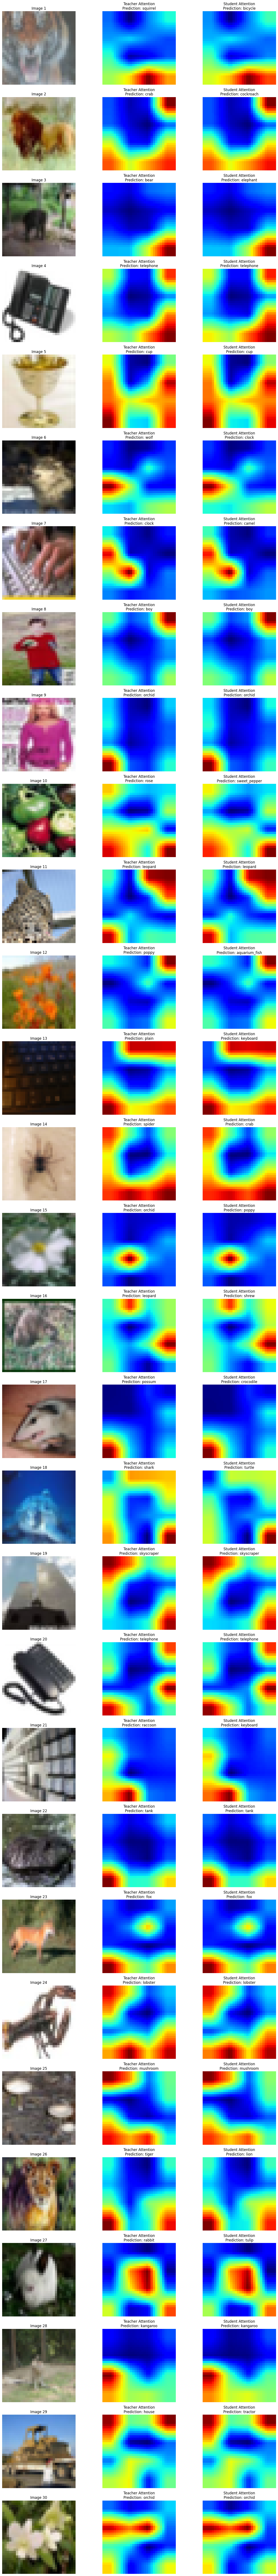

In [12]:

def TS_visualize_attention(teacher_model, student_model, output=None, device="cuda", num_images=30):
    """
    Visualize the attention maps of the images for both teacher and student models on CIFAR-100.
    """
    teacher_model.eval()
    student_model.eval()

    # Load random images from CIFAR-100
    testset = datasets.CIFAR100(root='./data', train=False, download=True)  # importing CIFAR100
    classes = testset.classes
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]  # randomly obtaining images from CIFAR 100
    labels = [testset[i][1] for i in indices]  # obtaining the associated labels

    # Convert images to tensors
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    images = images.to(device)

    # Get attention maps for both teacher and student models
    with torch.no_grad():  # Disable gradient computation
        teacher_logits, teacher_attention = teacher_model(images, output_attentions=True)
        student_logits, student_attention = student_model(images, output_attentions=True)

    teacher_predictions = torch.argmax(teacher_logits, dim=1)
    student_predictions = torch.argmax(student_logits, dim=1)
    
    teacher_attention = teacher_attention[0]  
    student_attention = student_attention[0]


    teacher_attention = teacher_attention[:, :, 0, 1:].mean(dim=1)
    student_attention = student_attention[:, :, 0, 1:].mean(dim=1)
    
    # Reshape and process attention maps
    num_patches = teacher_attention.size(-1)
    size = int(math.sqrt(num_patches))
    teacher_attention = teacher_attention.view(-1, size, size)
    student_attention = student_attention.view(-1, size, size)
    teacher_attention = F.interpolate(teacher_attention.unsqueeze(1), size=(32, 32), mode='bilinear', align_corners=False).squeeze(1)
    student_attention = F.interpolate(student_attention.unsqueeze(1), size=(32, 32), mode='bilinear', align_corners=False).squeeze(1)

    # Plot images and attention maps
    cols = 3
    rows = num_images
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*num_images))  # Adjusted size for better visualization
    for i in range(num_images):
        axes[i, 0].imshow(raw_images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {i+1}")

        axes[i, 1].imshow(teacher_attention[i].detach().cpu(), cmap='jet')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Teacher Attention\nPrediction: {classes[teacher_predictions[i].item()]}")

        axes[i, 2].imshow(student_attention[i].detach().cpu(), cmap='jet')
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Student Attention\nPrediction: {classes[student_predictions[i].item()]}")

    plt.tight_layout()
    if output is not None:
        plt.savefig(output)
    plt.show()

TS_visualize_attention(teacher_model, student_model, output=None, device='cuda')